# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    

np.random.seed(42)

# CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

## Preparing the Data
Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [2]:
import glob
def findFiles(path): 
    return glob.glob(path)

all_filenames = findFiles('data/names/*.txt')
print(all_filenames)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

x = 'Ślusàrski'
for c in unicodedata.normalize('NFD', x):
    print(c, unicodedata.category(c))

Slusarski
S Lu
́ Mn
l Ll
u Ll
s Ll
a Ll
̀ Mn
r Ll
s Ll
k Ll
i Ll


In [12]:
#str.split() # преобразует строку в список слов - "разделяет строку" (вспоминаем ADSL сплиттеры), по умолчанию разделение идёт на пробелы, но можно задать любой разделитель
open(all_filenames[0]).read().strip().split('\n')

['Khoury',
 'Nahas',
 'Daher',
 'Gerges',
 'Nazari',
 'Maalouf',
 'Gerges',
 'Naifeh',
 'Guirguis',
 'Baba',
 'Sabbagh',
 'Attia',
 'Tahan',
 'Haddad',
 'Aswad',
 'Najjar',
 'Dagher',
 'Maloof',
 'Isa',
 'Asghar',
 'Nader',
 'Gaber',
 'Abboud',
 'Maalouf',
 'Zogby',
 'Srour',
 'Bahar',
 'Mustafa',
 'Hanania',
 'Daher',
 'Tuma',
 'Nahas',
 'Saliba',
 'Shamoon',
 'Handal',
 'Baba',
 'Amari',
 'Bahar',
 'Atiyeh',
 'Said',
 'Khouri',
 'Tahan',
 'Baba',
 'Mustafa',
 'Guirguis',
 'Sleiman',
 'Seif',
 'Dagher',
 'Bahar',
 'Gaber',
 'Harb',
 'Seif',
 'Asker',
 'Nader',
 'Antar',
 'Awad',
 'Srour',
 'Shadid',
 'Hajjar',
 'Hanania',
 'Kalb',
 'Shadid',
 'Bazzi',
 'Mustafa',
 'Masih',
 'Ghanem',
 'Haddad',
 'Isa',
 'Antoun',
 'Sarraf',
 'Sleiman',
 'Dagher',
 'Najjar',
 'Malouf',
 'Nahas',
 'Naser',
 'Saliba',
 'Shamon',
 'Malouf',
 'Kalb',
 'Daher',
 'Maalouf',
 'Wasem',
 'Kanaan',
 'Naifeh',
 'Boutros',
 'Moghadam',
 'Masih',
 'Sleiman',
 'Aswad',
 'Cham',
 'Assaf',
 'Quraishi',
 'Shalhoub',
 '

In [13]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [14]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors
To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [15]:
print(type(all_letters))
all_letters.find('d')

<class 'str'>


3

In [16]:
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

print(line_to_tensor('Jones'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Creating the Network
Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [17]:
urs = 'https://i.imgur.com/Z2xbySO.png'
from IPython.display import Image
from IPython.core.display import HTML 
Image(width=500, height=10, url= urs)

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.9238, -2.8802, -2.9464, -2.8609, -2.9619, -3.0289, -2.9253, -2.7670,
         -2.8574, -2.8444, -2.8399, -2.8201, -2.9763, -2.8503, -2.9958, -2.8870,
         -2.7802, -2.9257]], grad_fn=<LogSoftmaxBackward>)

## Training

In [22]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 7)


In [34]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [35]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Sokolofsky
category = Portuguese / line = Estves
category = Russian / line = Hersonsky
category = Russian / line = Vinichenko
category = Czech / line = Slejtr
category = Scottish / line = Young
category = Italian / line = Noschese
category = English / line = Nineham
category = Spanish / line = Blanco
category = Dutch / line = Teunissen


In [36]:
criterion = nn.NLLLoss()

In [37]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [38]:
randomTrainingExample()

('Dutch',
 'Peter',
 tensor([3]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.2485 Isoda / Japanese ✓
10000 10% (0m 17s) 2.3165 Diarmaid / Japanese ✗ (Irish)
15000 15% (0m 25s) 1.9728 Stluka / Polish ✗ (Czech)
20000 20% (0m 34s) 1.0138 Sokolofsky / Polish ✓
25000 25% (0m 42s) 3.1668 Kranz / German ✗ (Dutch)
30000 30% (0m 51s) 0.4613 Kaibara / Japanese ✓
35000 35% (0m 59s) 4.4047 Meeuwis / Greek ✗ (Dutch)
40000 40% (1m 8s) 0.2821 Yoon / Korean ✓
45000 45% (1m 16s) 3.3256 Salomon / English ✗ (Polish)
50000 50% (1m 25s) 0.7087 Szwedko / Polish ✓
55000 55% (1m 33s) 0.6822 Kassis / Arabic ✓
60000 60% (1m 42s) 0.3199 Vamvakidis / Greek ✓
65000 65% (1m 50s) 0.1374 Kosmatka / Polish ✓
70000 70% (1m 59s) 0.4346 Sook / Korean ✓
75000 75% (2m 7s) 1.0463 Nie / Chinese ✓
80000 80% (2m 16s) 0.9442 Thi / Chinese ✗ (Vietnamese)
85000 85% (2m 25s) 1.7394 Ruan / Irish ✗ (Chinese)
90000 90% (2m 33s) 1.2020 Sluaghadhan / Russian ✗ (Irish)
95000 95% (2m 42s) 3.0412 Cot / Korean ✗ (French)
100000 100% (2m 51s) 0.7046 Tao / Chinese ✓


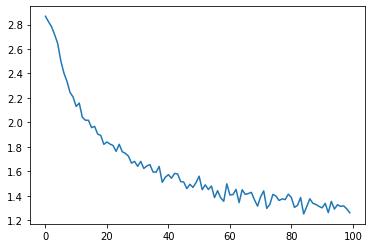

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

In [21]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

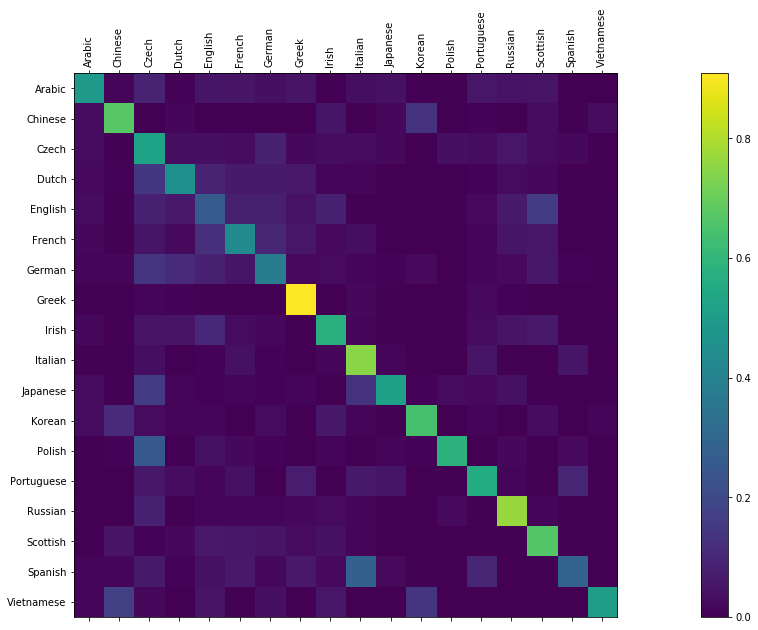

Accuracy = 0.5558723873562283


In [36]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

acc = 0
for i in range(n_categories):
    acc += confusion[i, i]
acc = acc.item()/confusion.sum().item()
print('Accuracy = {acc}'.format(acc = acc))

In [37]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.48) Russian
(-1.20) Czech
(-2.95) English

> Jackson
(-0.80) Scottish
(-1.39) English
(-2.18) Czech

> Satoshi
(-0.51) Italian
(-2.46) Japanese
(-2.75) Czech


# GENERATING NAMES WITH A CHARACTER-LEVEL RNN
We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

## Preparing the data / скопировано с прошлого


In [39]:
import glob
def findFiles(path): 
    return glob.glob(path)

all_filenames = findFiles('data/names/*.txt')
print(all_filenames)

import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


## Creating the Network

In [40]:
urs = 'https://i.imgur.com/jzVrf7f.png'
from IPython.display import Image
from IPython.core.display import HTML 
Image(width=500, height=10, url= urs)

In [69]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Preparing for Training

In [40]:
import random

# Get a random category and random line from that category
def randomTrainingPair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [41]:
randomTrainingPair()

('Russian', 'Baistryuchenko')

For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

In [44]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

categoryTensor('Korean')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [47]:
all_letters.find('d')

3

In [45]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

inputTensor('dann')

tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [48]:
# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

targetTensor('dann')

tensor([ 0, 13, 13, 56])

For convenience during training we’ll make a randomTrainingExample function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [51]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

randomTrainingExample()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

## Training

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [67]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [58]:
category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
target_line_tensor.size()

torch.Size([7])

In [62]:
target_line_tensor.unsqueeze_(-1).size()

torch.Size([7, 1])

In [65]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [70]:
rnn = RNN(n_letters, 128, n_letters)
learning_rate = 0.0005
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 22s (5000 5%) 2.8337
0m 44s (10000 10%) 2.1535
1m 6s (15000 15%) 2.3134
1m 28s (20000 20%) 2.1792
1m 50s (25000 25%) 2.2528
2m 12s (30000 30%) 1.6144
2m 34s (35000 35%) 2.7848
2m 56s (40000 40%) 2.1975
3m 18s (45000 45%) 1.3010
3m 41s (50000 50%) 3.1835


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sampling the Network
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.


In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')